## Ancillary tools

Scott Wales at CLEX created a few tools to help create ancillaries for regional nested suite.


### Exercise

Plan out creating ancillaries for your own domain (max 200x200 grid size)

At the boundary of the regional domain the model is merged with the driving lateral boundary conditions. The driving data always has to be a bit larger than the target domain, you can't for instance have an outer nest domain and an inner nest domain share the same edge.

Boundary data can be saved as a 'frame', where the innermost part of the data is cut out leaving only data around the edge. In this case the frame has to cover from the domain's 'halo' to the domain's 'rim' (both configurable in the model's LBC configuration).

Here's some Python code to plot out the region that may be helpful when planning your domain.

> **__NOTE__** This code and some examples are now available at 
> https://github.com/21centuryweather/UM_configuration_tools/blob/main/UM_plot_domain.ipynb
>

In [ ]:
import typing as T
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import numpy

def plot_region(ax, name: str, centre: T.Tuple[float, float], res: T.Tuple[float, float], size: T.Tuple[int, int], pole: T.Tuple[float, float]=(90,180), rim: int=9, halo: T.Tuple[int, int]=(7,7), **kwargs):
    """
    Plots a LAM region, including its rim and halo
    """
    
    draw_box_centre_size(ax, name, centre, res, size, pole, **kwargs)
    
    rim_size = [size[0]-rim*2, size[1]-rim*2]
    draw_box_centre_size(ax, name + '_rim', centre, res, rim_size, pole, ls='--', **kwargs)
    
    halo_size = [size[0]+halo[0]*2, size[1]+halo[1]*2]
    draw_box_centre_size(ax, name + '_halo', centre, res, halo_size, pole, ls=':', **kwargs)
    
def draw_box_centre_size(ax, name: str, centre: T.Tuple[float, float], res: T.Tuple[float, float], size: T.Tuple[int, int], pole: T.Tuple[float, float]=(90,180), **kwargs):
    """
    Draws a box given its centre and size
    """
    size_lon = res[1] * size[1]
    size_lat = res[0] * size[0]

    draw_box_corners(ax, name, corners=[centre[1]-size_lon/2, centre[1]+size_lon/2, centre[0]-size_lat/2, centre[0]+size_lat/2], pole=pole, **kwargs)
    
def draw_box_corners(ax, name: str, corners: T.Tuple[float, float, float, float], pole: T.Tuple[float, float]=(90,180), **kwargs):
    """
    Draws a box given its corners
    """
    x0,x1,y0,y1 = corners
    
    lons = numpy.linspace(x0,x1)
    lats = numpy.linspace(y0,y1)
        
    crs = ccrs.RotatedGeodetic(pole[1], pole[0])
    ax.plot(lons, [y0]*lons.size, transform=crs, **kwargs, label=name) 
    ax.plot(lons, [y1]*lons.size, transform=crs, **kwargs) 
    ax.plot([x0]*lats.size, lats, transform=crs, **kwargs) 
    ax.plot([x1]*lats.size, lats, transform=crs, **kwargs) 

Matplotlib is building the font cache; this may take a moment.


In [2]:
import iris
import iris.plot

frames_se = iris.load_cube('/scratch/nf33/saw562/nri-workshop-tutorial/barra-frames/20200119T1800Z/frame_barra-se', 'air_potential_temperature')

/g/data/hh5/public/apps/miniconda3/envs/analysis3-23.04/lib/python3.9/site-packages/iris/coords.py:2070: UserWarning: Coordinate 'longitude' is not bounded, guessing contiguous bounds.
  warnings.warn(
/g/data/hh5/public/apps/miniconda3/envs/analysis3-23.04/lib/python3.9/site-packages/iris/coords.py:2070: UserWarning: Coordinate 'latitude' is not bounded, guessing contiguous bounds.
  warnings.warn(


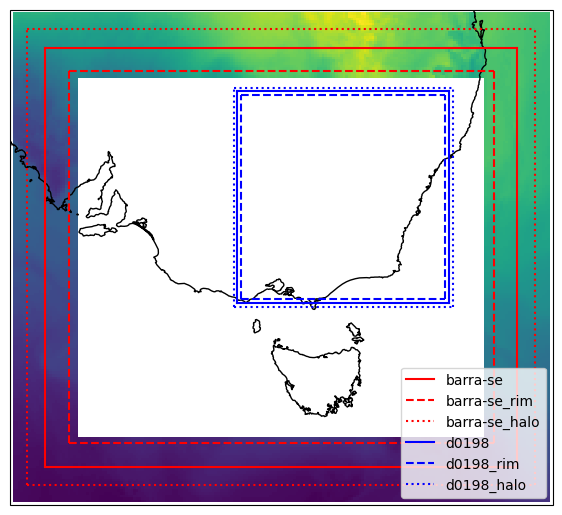

In [3]:
plt.figure(figsize=(7,7))
ax = plt.axes(projection=ccrs.PlateCarree())

iris.plot.pcolormesh(frames_se[0,0,:,], axes=ax)
plot_region(ax, 'barra-se', centre=[-36.96,145.02], res=[0.11, 0.11], size=[160,180], color='r')
plot_region(ax, 'd0198', centre=[-34.43,147.615], res=[0.0198,0.0198], size=[450,450], color='b')

ax.coastlines('10m')
ax.legend(loc='lower right');

## Rotated Poles

At high latitudes a regular lat-lon grid can become very distorted. In this case you can use a rotated pole to get more evenly sized grid cells.

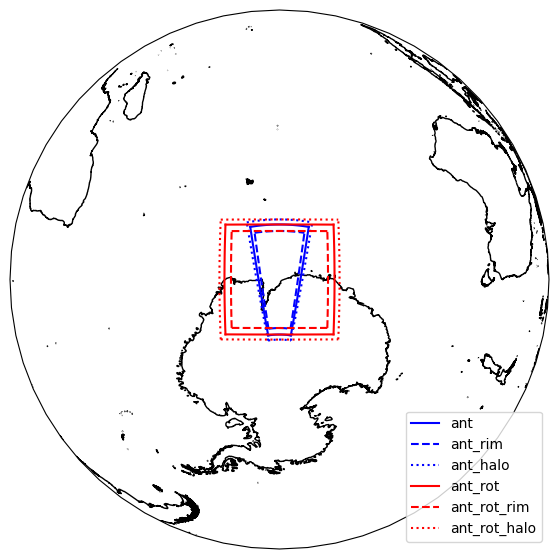

In [4]:
plt.figure(figsize=(7,7))
ax = plt.axes(projection=ccrs.NearsidePerspective(central_latitude=-68, central_longitude=78))

plot_region(ax, 'ant', centre=[-68,78], res=[0.135,0.135], size=[150,150], color='b')
plot_region(ax, 'ant_rot', centre=[0,0], res=[0.135,0.135], size=[150,150], pole=[90+68,180+78], color='r')

ax.set_global()
ax.coastlines('10m')
ax.legend(loc='lower right');

## Editing Ancillaries

You can edit ancilliaries in Python using the ANTS package. ANTS is based on Iris, and represents ancillaries as Iris cubes.

Load the most recent version of ANTS with
```shell
module use /g/data/access/ngm/modules
module load ants
```

An example of editing the land-sea mask is:
```python
import ants

cubes = ants.load('/home/562/saw562/cylc-run/u-cy368/share/data/ancils/aus2200/d0198/qrparm.mask')
cubes.extract_strict('land_binary_mask').data[300:350,300:350] = 0
cubes.extract_strict('land_area_fraction').data[300:350,300:350] = 0
ants.save(cubes, '/home/562/saw562/cylc-run/u-cy368/share/data/ancils/aus2200/d0198/qrparm.mask.edited')
```

You should check the ancillary file to make sure the edit is what you wanted:

/g/data/hh5/public/apps/miniconda3/envs/analysis3-23.04/lib/python3.9/site-packages/iris/coords.py:2070: UserWarning: Coordinate 'longitude' is not bounded, guessing contiguous bounds.
  warnings.warn(
/g/data/hh5/public/apps/miniconda3/envs/analysis3-23.04/lib/python3.9/site-packages/iris/coords.py:2070: UserWarning: Coordinate 'latitude' is not bounded, guessing contiguous bounds.
  warnings.warn(


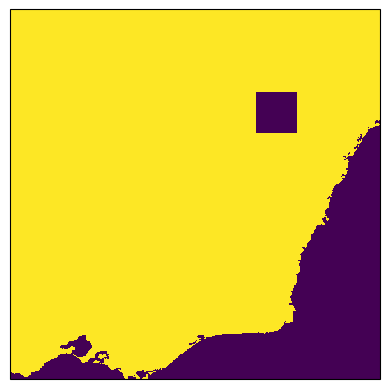

In [5]:
mask = iris.load_cube('/home/562/saw562/cylc-run/u-cy368/share/data/ancils/aus2200/d0198/qrparm.mask.edited', 'land_binary_mask')
iris.plot.pcolormesh(mask)

> **__NOTE__** To check your ancillaries have been generated correctly, you can use the following notebook:
>
>https://github.com/21centuryweather/UM_configuration_tools/blob/main/Check_UM_ancillaries.ipynb
>
>This notebook also contains logic to detect ancillary errors and it will identify missing ancillary data (i.e. 'NaNs' or 'Not-a-Number') in regions over land.
>
>Any UM forecast task will instantly fail if 'NaNs' are ingested into the forecast fields.
